In [2]:
# import packages
import os, sys, glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm.auto import tqdm
from ipywidgets import FloatProgress
from scipy import ndimage
from PIL import Image
from importlib import reload

sys.path.append('../')

## Plot Errors per Image

In [6]:
# options
image_path = "../pennycress_pods/test/test_images/"
pred_path = "../pennycress_pods/test/test_predictions/"
mask_path = "../pennycress_pods/test/test_masks/"
plot = True

# load image data
image_names = glob.glob(mask_path + "*.png")
image_names = [os.path.basename(x) for x in image_names]

  0%|          | 0/3 [00:00<?, ?it/s]

Processing image:  9_5.tt8t x fc5-1.B.WBP-2022.W_rep2.png
0.0 1.0
0.0 1.0
(2670, 3455, 3) 0 255


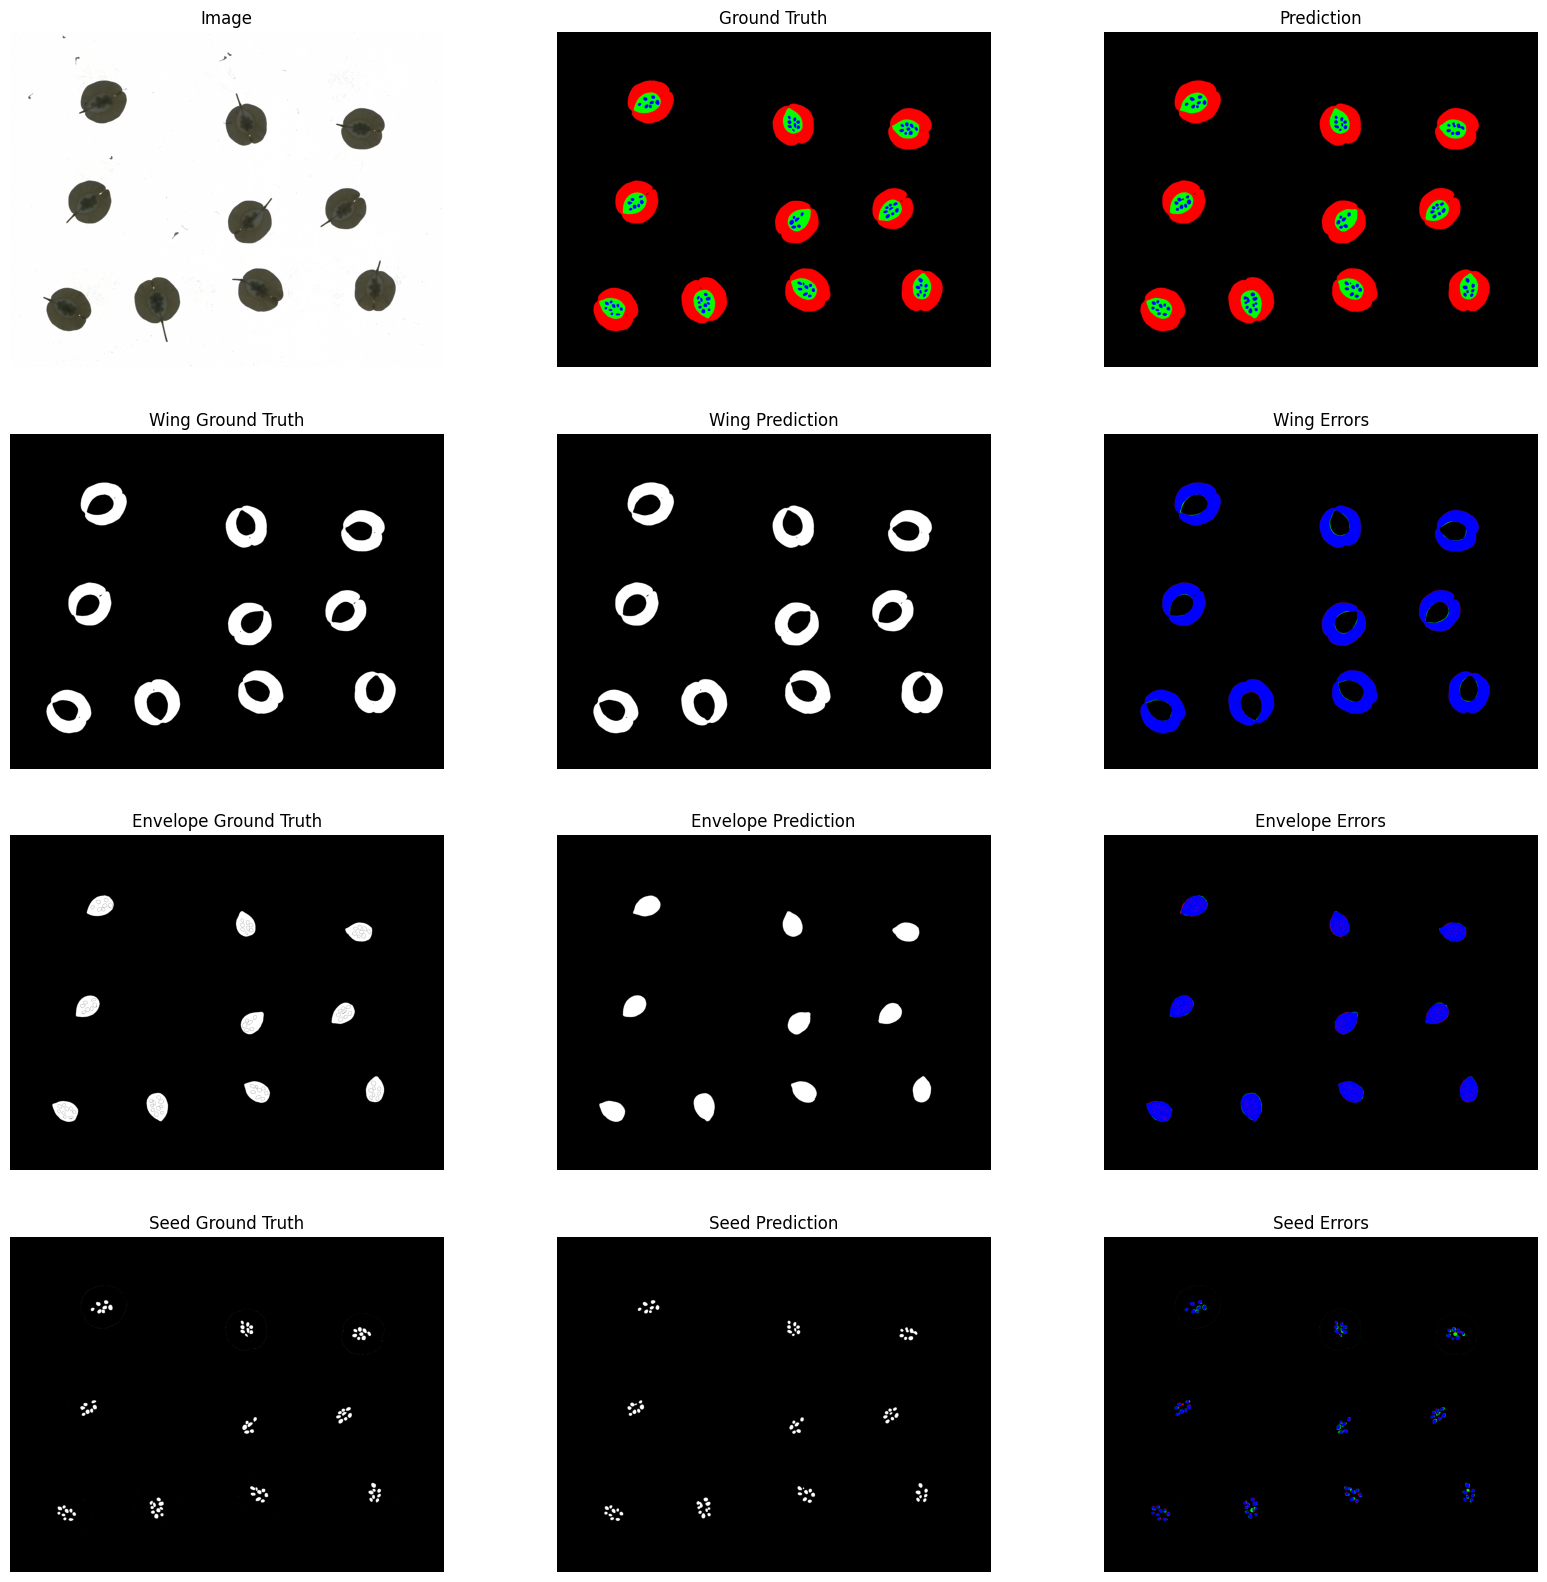

Processing image:  1.tt8t x fc6-1.B.WBP-2022.W.png
0.0 1.0
0.0 1.0
(2625, 3395, 3) 0 255


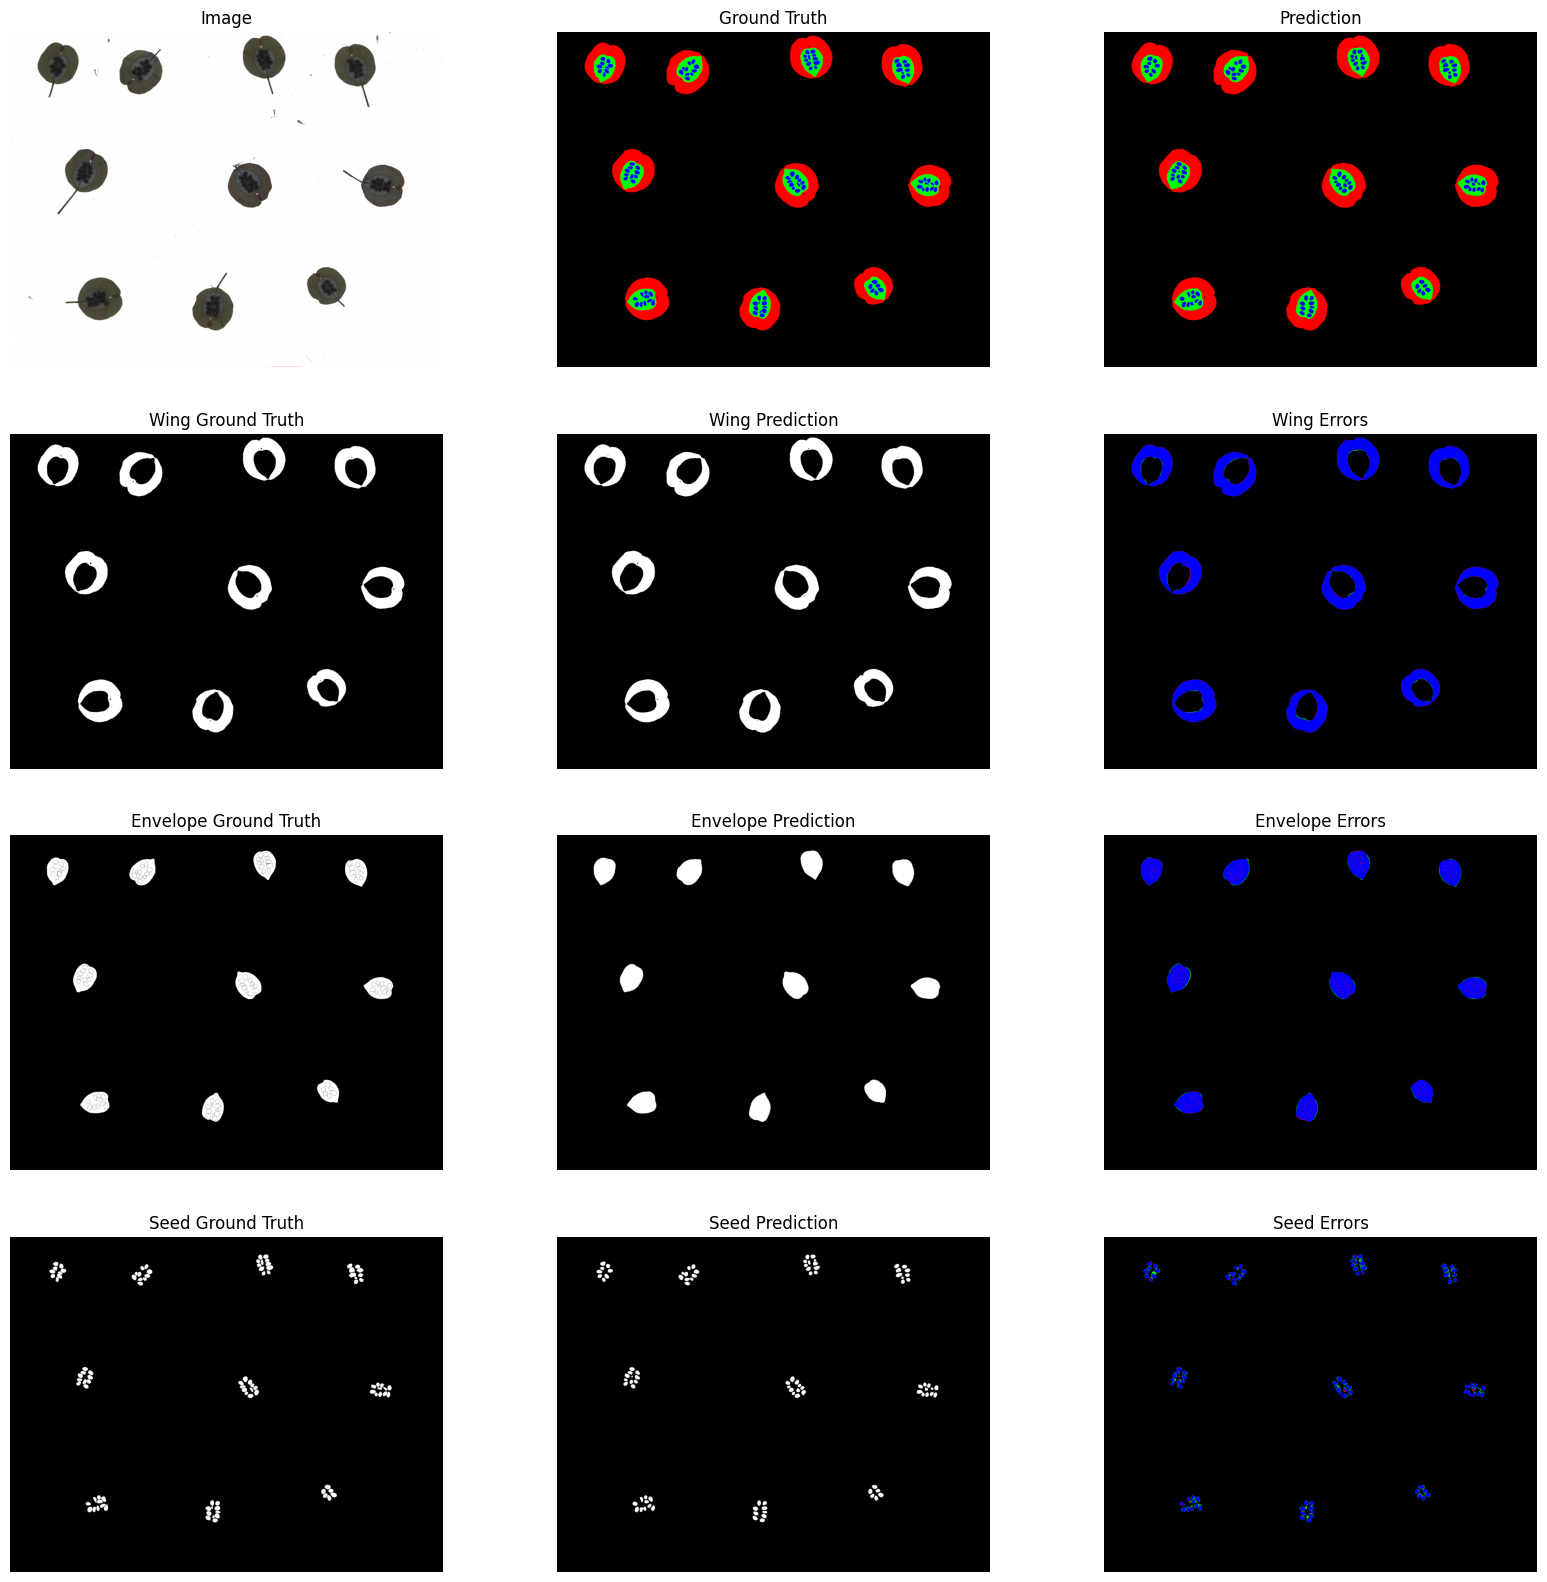

Processing image:  10.tt8t x fc5-2.B.WBP-2022.W.png
0.0 1.0
0.0 1.0
(2670, 3455, 3) 0 255


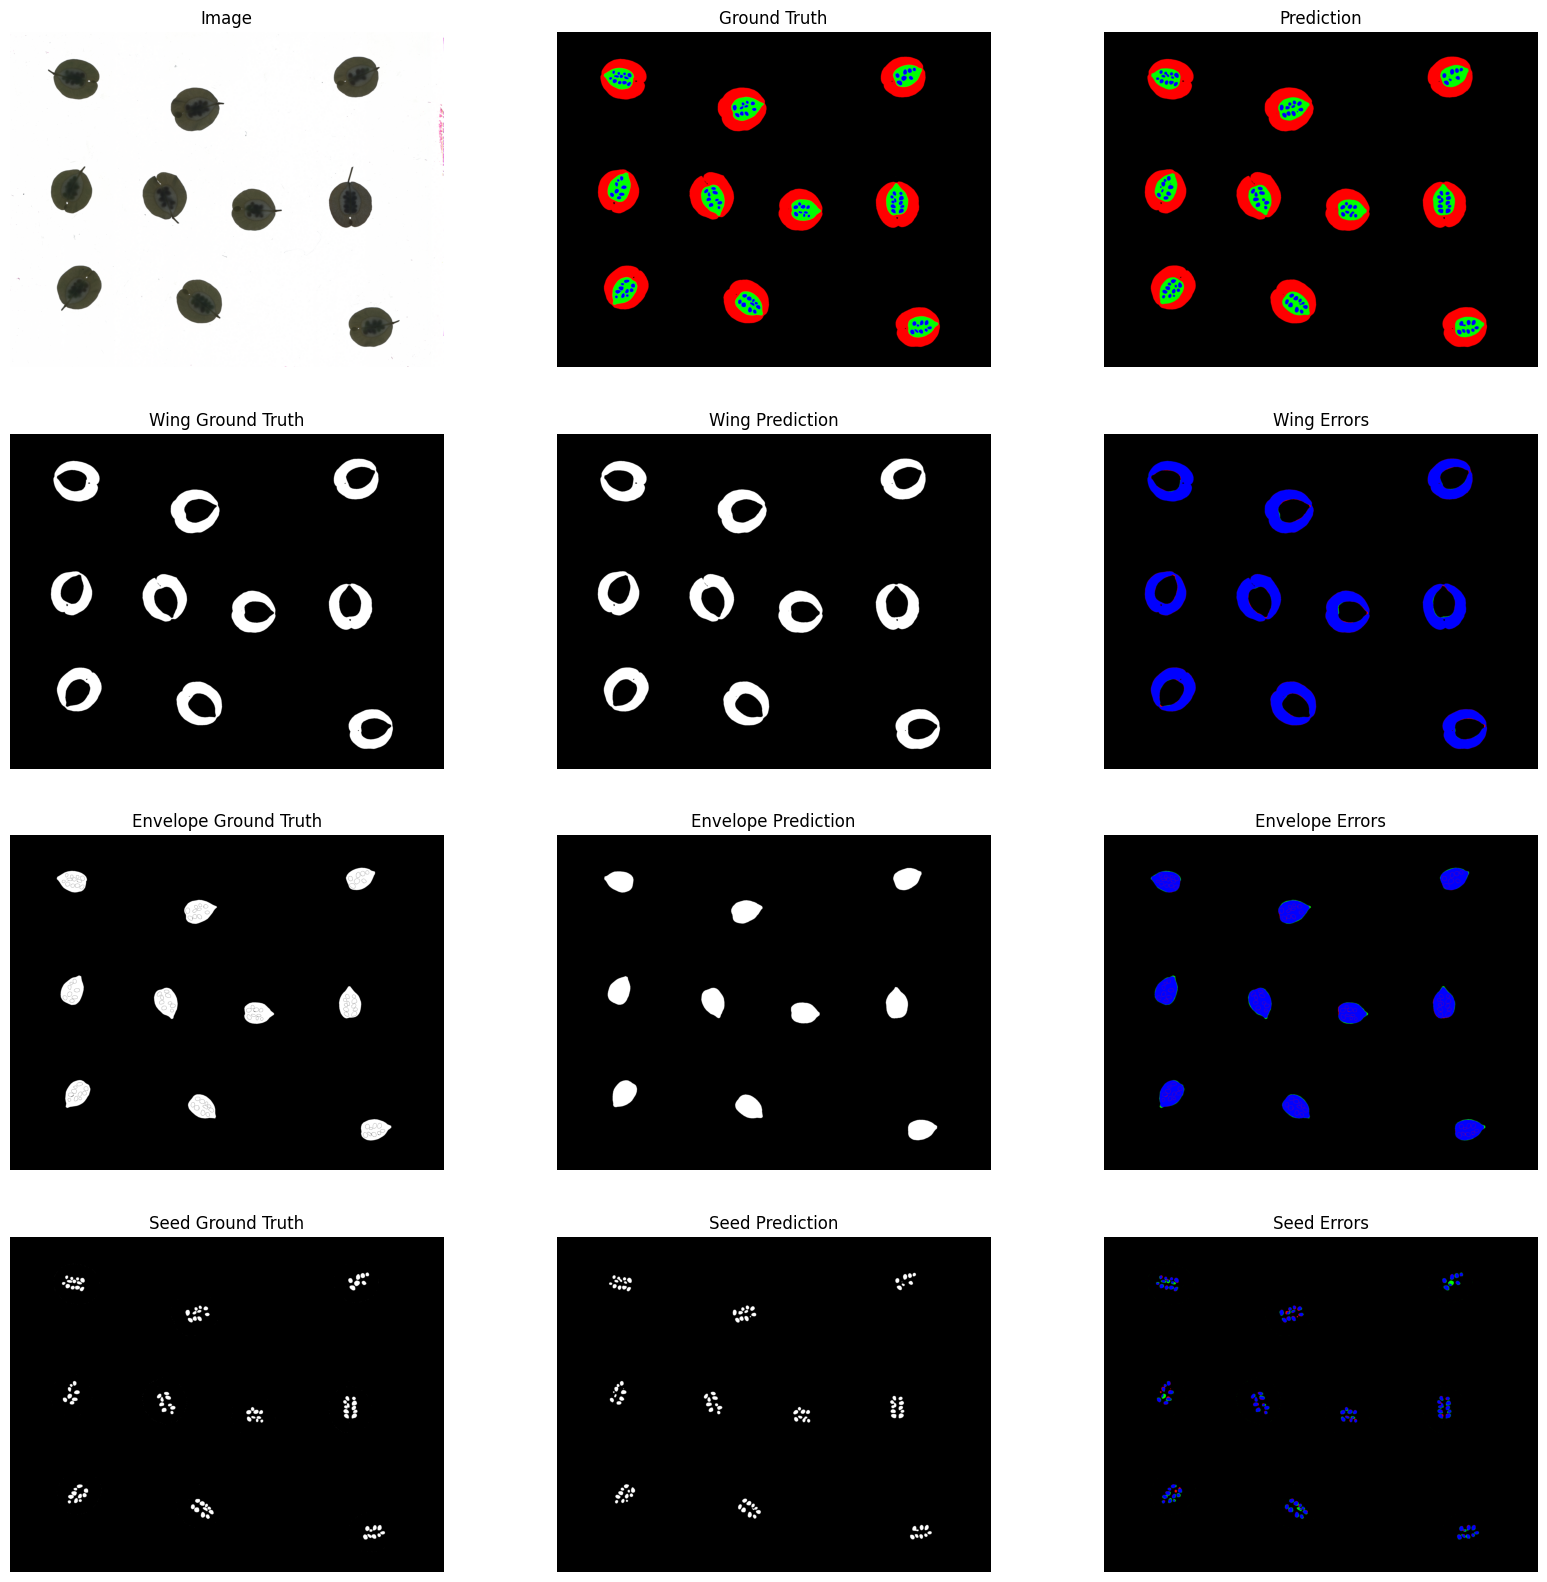

In [21]:

# loop through predicted images and compare to ground truth
with tqdm(total=len(image_names)) as pbar:
    for image_name in image_names:
        
        print("Processing image: ", image_name)

        # load images, mask, pred
        image = Image.open(image_path + image_name)
        image = np.array(image) / 255.0

        pred_image = Image.open(pred_path + f"pred_{image_name}")
        pred_image = np.array(pred_image) / 255.0
        pred_image[pred_image.sum(-1) == 3] = 0

        print(pred_image.min(), pred_image.max())

        mask = np.array(Image.open(mask_path + image_name))[:,:,:3] / 255.0

        # fix weird mask behavior - all px. values are 0 or 1
        mask[mask > 0] = 1
        print(mask.min(), mask.max())

        # separate into wing, seed, env channel
        wing_gt = mask[:, :, 0] == 1
        wing_pred = pred_image[:, :, 0] == 1

        wing_tp = np.logical_and(wing_pred, wing_gt)
        wing_fp = np.logical_and(wing_pred, ~wing_gt)
        wing_fn = np.logical_and(~wing_pred, wing_gt)
        wing_error = np.stack([wing_fp, wing_fn, wing_tp], axis = 2).astype(np.uint8) * 255
        print(wing_error.shape, wing_error.min(), wing_error.max())

        env_gt = mask[:, :, 1:].sum(-1) == 1 
        env_pred = pred_image[:, :, 1:].sum(-1) == 1 

        env_tp = np.logical_and(env_pred, env_gt)
        env_fp = np.logical_and(env_pred, ~env_gt)
        env_fn = np.logical_and(~env_pred, env_gt)
        env_error = np.stack([env_fp, env_fn, env_tp], axis=2).astype(np.uint8) * 255

        seed_gt = mask[:, :, 2] == 1
        seed_pred = pred_image[:, :, 2] == 1

        seed_tp = np.logical_and(seed_pred, seed_gt)
        seed_fp = np.logical_and(seed_pred, ~seed_gt)
        seed_fn = np.logical_and(~seed_pred, seed_gt)
        seed_error = np.stack([seed_fp, seed_fn, seed_tp], axis = 2).astype(np.uint8) * 255

        # calculate metrics (specificity, sensitivity, precision, etc.)

        if plot:
            # plot
            fig, ax = plt.subplots(4, 3, figsize=(20, 20))

            ## IMAGE
            ax[0, 0].imshow(image)
            ax[0, 0].set_title("Image")
            ax[0, 0].axis('off')

            ax[0, 1].imshow(mask)
            ax[0, 1].set_title("Ground Truth")
            ax[0, 1].axis('off')

            ax[0, 2].imshow(pred_image)
            ax[0, 2].set_title("Prediction")
            ax[0, 2].axis('off')

            ## WING
            ax[1, 0].imshow(wing_gt, cmap='gray')
            ax[1, 0].set_title("Wing Ground Truth")
            ax[1, 0].axis('off')

            ax[1, 1].imshow(wing_pred, cmap='gray')
            ax[1, 1].set_title("Wing Prediction")
            ax[1, 1].axis('off')

            ax[1, 2].imshow(wing_error)
            ax[1, 2].set_title("Wing Errors")
            ax[1, 2].axis('off')

            ## ENV
            ax[2, 0].imshow(env_gt, cmap='gray')
            ax[2, 0].set_title("Envelope Ground Truth")
            ax[2, 0].axis('off')

            ax[2, 1].imshow(env_pred, cmap='gray')
            ax[2, 1].set_title("Envelope Prediction")
            ax[2, 1].axis('off')

            ax[2, 2].imshow(env_error)
            ax[2, 2].set_title("Envelope Errors")
            ax[2, 2].axis('off')

            ## SEED
            ax[3, 0].imshow(seed_gt, cmap='gray')
            ax[3, 0].set_title("Seed Ground Truth")
            ax[3, 0].axis('off')

            ax[3, 1].imshow(seed_pred, cmap='gray')
            ax[3, 1].set_title("Seed Prediction")
            ax[3, 1].axis('off')

            ax[3, 2].imshow(seed_error)
            ax[3, 2].set_title("Seed Errors")
            ax[3, 2].axis('off')

            plt.show()
        pbar.update(1)
